<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkcyan"></p>

<div class="alert alert-success">  
    <h1 align="center" style="color:darkcyan;">🧬Open Problems – Single-Cell Perturbations</h1> 
    <h3 align="center" style="color:gray;">Predict how small molecules change gene expression in different cell types</h3> 
    <h3 align="center" style="color:gray;">By: Somayyeh Gholami & Mehran Kazeminia</h3> 
</div>

<p style="border-bottom: 5px solid darkcyan"></p>

# <div style="color:white;background-color:darkcyan;padding:2%;border-radius:15px 15px;font-size:1em;text-align:center">Feature Augmentation</div>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:gray;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightblue;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>Description for notebook number three :</p></div>

- This notebook is the continuation of [notebook number one](https://www.kaggle.com/code/mehrankazeminia/1-op2-eda-linearsvr-regressorchain).

- Two available features; are "cell_type" and "sm_name" and we want to add two new columns (two new features) to them.

- If we separate the cells based on 'cell_type' and assume that the drugs will usually have similar responses on each of these divisions, we can hope that by finding the average effects, we have obtained a new feature. For example, we will see that for y0 and the new feature of zero column, the correlation coefficient is 0.24. Of course, this amount is repeated for other columns as well.

- Also, if we separate the cells based on 'sm_name', we get a new feature by finding the average effects. In this case, for y0 and the new feature of column zero, the correlation coefficient is 0.62, and this value is almost repeated for other columns.

- Obviously, to add these two features, TrainData and TestData must be customized for each y column, and this may seem a bit complicated. For this reason, we first performed all the calculations only on column zero and then continued the main calculations in a loop with "range(y.shape[1])".

- By adding these two new features, the score of this notebook improved and probably the score of all notebooks that use the usual methods in machine learning (such as neural network, etc.) will be better.

- Of course, since the beginning of this challenge, many public notebooks have used averaging methods, but in these notebooks, the obtained values are directly considered as the answer.

- It should be noted that in the notebooks mentioned above, guesses are made to find the effect of averages or their combination, and these guesses will probably cause instability in the model as well as the risk of overfitting.

- Good luck.

![](https://cdn-images-1.medium.com/max/1000/1*46qnKu0BlU_cPafJwWeDHg.png)

In [1]:
import warnings # suppress warnings
warnings.filterwarnings('ignore')
#:::::::::::::::::::::::::::::::::::
import os
import gc
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
from itertools import groupby
#:::::::::::::::::::::::::::::::::::
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
!ls ../input/*

../input/op2-603:
op2_603.csv

../input/op2-604:
checkpoint		     model_1.index		  model_3.index
model_0.data-00000-of-00001  model_2.data-00000-of-00001  submission_df.csv
model_0.index		     model_2.index		  submission_preds
model_1.data-00000-of-00001  model_3.data-00000-of-00001

../input/op2-607:
OP2_607.csv

../input/op2-720:
op2_720.csv

../input/open-problems-single-cell-perturbations:
adata_obs_meta.csv   id_map.csv		     multiome_var_meta.csv
adata_train.parquet  multiome_obs_meta.csv   sample_submission.csv
de_train.parquet     multiome_train.parquet


<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>

<div>
    <h1 align="center" style="color:darkgray;">Competition Data (Eight files)</h1>
</div>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>(1) de_train.parquet</p></div>

In [2]:
de_train = pd.read_parquet('../input/open-problems-single-cell-perturbations/de_train.parquet')
de_train.shape

(614, 18216)

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>(7) id_map.csv</p></div>

In [3]:
id_map = pd.read_csv('../input/open-problems-single-cell-perturbations/id_map.csv')
id_map.shape

(255, 3)

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>(8) sample_submission.csv</p></div>

In [4]:
sample_submission = pd.read_csv('../input/open-problems-single-cell-perturbations/sample_submission.csv', index_col='id')
sample_submission.shape

(255, 18211)

<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>train | test | target</p></div>

In [5]:
xlist  = ['cell_type','sm_name']
_ylist = ['cell_type','sm_name','sm_lincs_id','SMILES','control']

y = de_train.drop(columns=_ylist)
y.shape

(614, 18211)

### <span style="color:navy;">get_dummies (OneHotEncoder)</span>

<p style="border-bottom: 5px solid navy"></p>

In [6]:
train = pd.get_dummies(de_train[xlist], columns=xlist)
train.shape

(614, 152)

In [7]:
test = pd.get_dummies(id_map[xlist], columns=xlist)
test.shape

(255, 131)

In [8]:
uncommon = [f for f in train if f not in test]

X = train.drop(columns=uncommon)
X.shape

(614, 131)

<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>Evaluation</p></div>

### <span style="color:navy;">Mean Rowwise Root Mean Squared Error (MRRMSE)</span>

In [9]:
def mrrmse_pd(y_pred: pd.DataFrame, y_true: pd.DataFrame):
    
    return ((y_pred - y_true)**2).mean(axis=1).apply(np.sqrt).mean()

In [10]:
def mrrmse_np(y_pred, y_true):
    
    return np.sqrt(np.square(y_true - y_pred).mean(axis=1)).mean()

<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>Feature Augmentation</p></div>

In [11]:
de_cell_type = de_train.iloc[:, [0] + list(range(5, de_train.shape[1]))]
de_sm_name = de_train.iloc[:, [1] + list(range(5, de_train.shape[1]))]

de_cell_type.shape, de_sm_name.shape

((614, 18212), (614, 18212))

### <span style="color:navy;">Calculate averages based on 'cell_type' and 'sm_name' for all columns</span>

<p style="border-bottom: 5px solid navy"></p>

In [12]:
mean_cell_type = de_cell_type.groupby('cell_type').mean().reset_index()
mean_sm_name = de_sm_name.groupby('sm_name').mean().reset_index()

display(mean_cell_type)
display(mean_sm_name)

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
1,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
2,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
3,T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
4,T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895
5,T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542


,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
142,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
143,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
144,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


### <span style="color:navy;">Paste the results into the train file</span>

<p style="border-bottom: 5px solid navy"></p>

In [13]:
rows = []
for name in de_cell_type['cell_type']:
    mean_rows = mean_cell_type[mean_cell_type['cell_type'] == name].copy()
    rows.append(mean_rows)

tr_cell_type = pd.concat(rows)
tr_cell_type = tr_cell_type.reset_index(drop=True)
tr_cell_type

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
1,T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
2,T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895
3,T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542
4,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542
610,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
611,T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
612,T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895


In [14]:
rows = []
for name in de_sm_name['sm_name']:
    mean_rows = mean_sm_name[mean_sm_name['sm_name'] == name].copy()
    rows.append(mean_rows)

tr_sm_name = pd.concat(rows)
tr_sm_name = tr_sm_name.reset_index(drop=True)
tr_sm_name

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
1,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
2,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
3,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
4,Mometasone Furoate,1.330514,0.089259,0.925070,1.059381,0.503060,0.996421,-0.006012,1.318401,0.011984,...,-0.157324,0.386411,0.330060,0.204926,0.231450,0.475624,0.274146,0.057875,-1.131550,0.613541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Atorvastatin,0.280193,-0.105356,0.014759,0.052414,-0.274411,-0.044712,-0.373036,0.113470,-0.321457,...,-0.198790,-0.143693,0.355118,-0.312425,0.264163,0.189755,-0.069407,0.077091,0.013840,-0.610520
610,Riociguat,-0.193340,-0.061178,-0.117600,-0.493997,0.004746,-0.350414,-0.081786,-0.467478,-0.114670,...,-0.230258,-1.059673,-0.272358,-0.160014,-0.326247,0.231997,0.133820,-0.268421,0.330302,-0.721409
611,Riociguat,-0.193340,-0.061178,-0.117600,-0.493997,0.004746,-0.350414,-0.081786,-0.467478,-0.114670,...,-0.230258,-1.059673,-0.272358,-0.160014,-0.326247,0.231997,0.133820,-0.268421,0.330302,-0.721409
612,Riociguat,-0.193340,-0.061178,-0.117600,-0.493997,0.004746,-0.350414,-0.081786,-0.467478,-0.114670,...,-0.230258,-1.059673,-0.272358,-0.160014,-0.326247,0.231997,0.133820,-0.268421,0.330302,-0.721409


### <span style="color:navy;">Paste the results into the test file</span>

<p style="border-bottom: 5px solid navy"></p>

In [15]:
rows = []
for name in id_map['cell_type']:
    mean_rows = mean_cell_type[mean_cell_type['cell_type'] == name].copy()
    rows.append(mean_rows)

te_cell_type = pd.concat(rows)
te_cell_type = te_cell_type.reset_index(drop=True)
te_cell_type

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
1,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
2,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
3,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
4,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
251,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
252,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
253,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723


In [16]:
rows = []
for name in id_map['sm_name']:
    mean_rows = mean_sm_name[mean_sm_name['sm_name'] == name].copy()
    rows.append(mean_rows)

te_sm_name = pd.concat(rows)
te_sm_name = te_sm_name.reset_index(drop=True)
te_sm_name

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
251,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
252,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
253,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>LinearSVR - Sample: For column number zero (A1BG)</p></div>

In [17]:
y0 = y.iloc[:, 0].copy()
y0

0      0.104720
1      0.915953
2     -0.387721
3      0.232893
4      4.290652
         ...   
609   -0.014372
610   -0.455549
611    0.338168
612    0.101138
613   -0.757116
Name: A1BG, Length: 614, dtype: float64

In [18]:
X0 = X.join(tr_cell_type.iloc[:, 0+1]).copy()
X0 = X0.join(tr_sm_name.iloc[:, 0+1], lsuffix='_cell_type', rsuffix='_sm_name')
X0

,cell_type_B cells,cell_type_Myeloid cells,sm_name_5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,sm_name_ABT-199 (GDC-0199),sm_name_ABT737,sm_name_AMD-070 (hydrochloride),sm_name_AT 7867,sm_name_AT13387,sm_name_AVL-292,sm_name_AZ628,...,sm_name_Tosedostat,sm_name_Trametinib,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279,A1BG_cell_type,A1BG_sm_name
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.417735,0.216461
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.020208,0.216461
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.028166,0.216461
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.733468,0.216461
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.417735,1.330514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.733468,0.280193
610,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.417735,-0.193340
611,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.020208,-0.193340
612,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.028166,-0.193340


In [19]:
test0 = test.join(te_cell_type.iloc[:, 0+1]).copy()
test0 = test0.join(te_sm_name.iloc[:, 0+1], lsuffix='_cell_type', rsuffix='_sm_name')
test0

,cell_type_B cells,cell_type_Myeloid cells,sm_name_5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,sm_name_ABT-199 (GDC-0199),sm_name_ABT737,sm_name_AMD-070 (hydrochloride),sm_name_AT 7867,sm_name_AT13387,sm_name_AVL-292,sm_name_AZ628,...,sm_name_Tosedostat,sm_name_Trametinib,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279,A1BG_cell_type,A1BG_sm_name
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1.380890,0.300267
1,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1.380890,-0.081286
2,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1.380890,0.408012
3,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,1.380890,-0.031131
4,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,1.380890,0.242736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,1.570336,-0.006076
251,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,1.570336,0.188002
252,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,1.570336,-0.097319
253,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,1.570336,0.075208


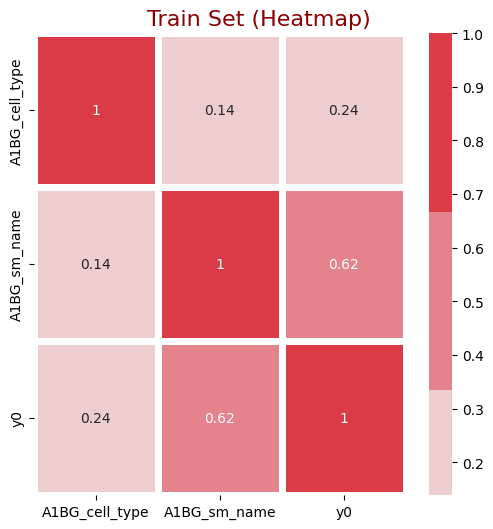

In [20]:
X0_corr = X0.copy()
X0_corr['y0'] = y0

cor_matrix = X0_corr.iloc[: , 131:].corr()
fig = plt.figure(figsize=(6,6));

cmap=sns.diverging_palette(240, 10, s=75, l=50, sep=1, n=6, center='light', as_cmap=False);
sns.heatmap(cor_matrix, center=0, annot=True, cmap=cmap, linewidths=5);
plt.suptitle('Train Set (Heatmap)', y=0.92, fontsize=16, c='darkred');
plt.show()

In [21]:
corr = X0_corr.iloc[: , 131:].corr(numeric_only=True).round(3)
corr.style.background_gradient(cmap='Pastel1')

,A1BG_cell_type,A1BG_sm_name,y0
A1BG_cell_type,1.000000,0.139000,0.242000
A1BG_sm_name,0.139000,1.000000,0.618000
y0,0.242000,0.618000,1.000000


### <span style="color:navy;">LinearSVR - Column #0</span>

<p style="border-bottom: 5px solid navy"></p>

In [22]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.20, random_state=421)

In [23]:
model = LinearSVR(max_iter= 2000, epsilon= 0.1)
model.fit(X_train, y_train)

LinearSVR(epsilon=0.1, max_iter=2000)

In [24]:
predict = model.predict(X_test) 
# mrrmse_pd(pd.DataFrame(predict), pd.DataFrame(y_test.values))

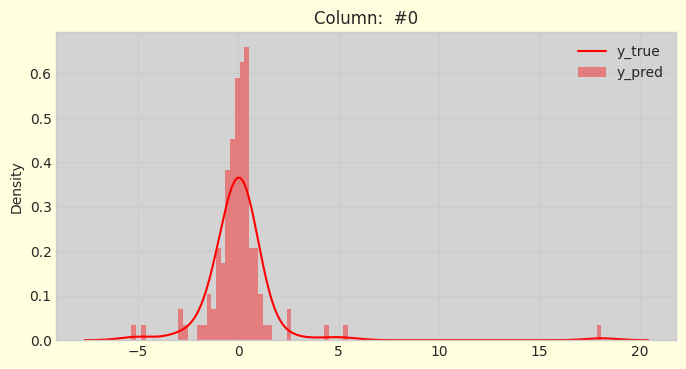

In [25]:
N = 0
plt.style.use('seaborn-whitegrid') 
plt.figure(figsize=(8, 4), facecolor='lightyellow')
plt.title(f'Column:  #{N}', fontsize=12)
plt.gca().set_facecolor('lightgray')

sns.distplot(y_test.values-predict, bins=100, color='red')
plt.legend(['y_true','y_pred'], loc=1)
plt.show()

<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>LinearSVR - Final mode</p></div>

In [26]:
model = LinearSVR(max_iter= 2000, epsilon= 0.1)

pred = []
for i in range(y.shape[1]):
    
    yi = y.iloc[:, i].copy()
    
    Xi = X.join(tr_cell_type.iloc[:, i+1]).copy()
    Xi = Xi.join(tr_sm_name.iloc[:, i+1], lsuffix='_cell_type', rsuffix='_sm_name')
    
    testi = test.join(te_cell_type.iloc[:, i+1]).copy()
    testi = testi.join(te_sm_name.iloc[:, i+1], lsuffix='_cell_type', rsuffix='_sm_name')
    
    model.fit(Xi, yi)
    pred.append(model.predict(testi))
    
len(pred)

18211

In [27]:
prediction = pd.DataFrame(pred).T
prediction.columns = de_train.columns[5:]
prediction.index.name = 'id'
prediction

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.299644,0.198953,0.323338,1.139607,0.677238,0.420702,0.093232,0.241529,-0.307053,0.240897,...,-0.646368,-0.403115,-0.003013,0.987763,0.613899,0.642542,0.578604,0.755671,-0.280290,0.678857
1,-0.021072,0.015594,0.254913,0.178418,0.549222,0.182567,-0.041666,-0.028933,0.826430,0.133972,...,0.034606,0.157693,-0.065198,0.269846,0.278707,-0.318406,0.373884,0.135398,-0.227508,0.101554
2,0.444060,0.279721,0.080184,0.154037,0.814346,1.002071,0.477141,0.206077,0.179649,0.286619,...,-0.054109,-0.150508,0.080837,0.750923,0.192640,0.190575,0.499338,0.248628,-0.164081,-0.317716
3,-0.149107,0.175950,0.188791,0.342772,0.351327,0.182020,-0.169158,0.643793,0.297181,0.446795,...,-0.131305,0.009987,0.186931,0.531210,0.120618,0.053723,0.289216,0.525464,-0.067557,0.291744
4,0.257968,-0.190177,0.219158,0.359578,0.414714,0.160123,-0.295003,0.208726,0.179616,0.479099,...,-0.688693,-0.066607,-0.014893,0.150296,0.253529,0.139124,0.179453,0.911365,-0.094086,0.225053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.426246,-0.563328,-0.142831,-0.262574,1.538941,-0.041643,0.242584,0.133974,0.046223,0.848693,...,-0.136488,-0.313805,-0.287885,-0.475620,0.293714,-0.286129,-0.388433,-0.364409,-0.162485,0.129175
251,0.566839,-0.395986,0.127305,0.291315,1.783238,0.685224,-0.007239,-0.144540,0.029724,0.445378,...,-0.259968,-0.300148,0.168653,-0.320175,0.571295,-0.366226,-0.634766,-0.098117,-0.375765,-0.211307
252,0.492423,0.505905,-0.063227,0.025577,1.567722,0.220976,0.091198,-0.427648,0.295893,0.630751,...,-0.218159,-0.324201,0.913596,-0.300187,0.403872,-0.448365,-0.605000,-0.185523,0.040413,-0.432396


In [28]:
prediction.to_csv('prediction.csv')
!ls

__notebook__.ipynb  prediction.csv


<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:navy;font-block:Nexa;overflow:hidden"><p style="padding:15px;color:lightgray;overflow:hidden;font-size:70%;letter-spacing:0.5px;margin:0"><b> </b>Ensembling</p></div>

Several public notebooks presented different methods based on averaging, different guesses, etc. The following file is actually the optimization and ensembling of these results.

Thanks to: **@alexandervc**

In [29]:
import1 = pd.read_csv('../input/op2-603/op2_603.csv', index_col='id')
import1.shape

(255, 18211)

The file below is the result of a great notebook that uses the "Autoencoder" method.

Thanks to: **@vendekagonlabs**

In [30]:
import2 = pd.read_csv('../input/op2-720/op2_720.csv', index_col='id')
import2.shape

(255, 18211)

The file below is the result of a great notebook that uses the "Neural Network" method.

Thanks to: **@kishanvavdara**

In [31]:
import3 = pd.read_csv('../input/op2-604/submission_df.csv', index_col='id')
import3.shape

(255, 18211)

The file below is the result of a great notebook that uses the "NLP" method.

Thanks to: **@kishanvavdara**

In [32]:
import4 = pd.read_csv('../input/op2-607/OP2_607.csv', index_col='id')
import4.shape

(255, 18211)

In [33]:
col = list(de_train.columns[5:])
submission = sample_submission.copy()

submission[col] = (import1[col] *0.33) + (import2[col] *0.12) + (import3[col] *0.25) + (import4[col] *0.20) + (prediction[col] *0.10)
submission.shape

(255, 18211)

In [34]:
submission.to_csv('submission.csv')
!ls

__notebook__.ipynb  prediction.csv  submission.csv


### <span style="color:navy;">Ensembling Histograms</span>

<p style="border-bottom: 5px solid navy"></p>

In [35]:
N = random.randrange(y.shape[1])

print(':' *40)
print('Column number :', N)
print('Column name :', list(y.columns)[N])
print(':' *40)

hist_data = [submission.iloc[:, N], import1.iloc[:, N], import2.iloc[:, N], import3.iloc[:, N], import4.iloc[:, N], prediction.iloc[:, N]]
group_labels = ['Submission', 'Mean & Paste', 'Autoencoder', 'Neural Network', 'NLP', 'Prediction']
    
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2, show_hist=False, show_rug=False)
fig.show()

::::::::::::::::::::::::::::::::::::::::
Column number : 16859
Column name : UBFD1
::::::::::::::::::::::::::::::::::::::::


<div class="alert alert-success">  
</div>

<p style="border-bottom: 5px solid darkgray"></p>